In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import scipy as sp
from mec import make_circle
import itertools
from networkx.algorithms.approximation import maximum_independent_set
%matplotlib inline

In [2]:
def distance(H):
    for i in range(1, 2**len(H[0])):
        num = bin(i)[2:].zfill(len(H[0]))
        sum = np.zeros(len(H), dtype=np.int8)
        for j in range(len(num)):
            if (num[j] == '1'):
                sum = sum^H[:,j]
        if ((sum == np.zeros(len(H))).all()):
            return num.count('1')

In [8]:
# (3, 4)-LDPC code using Gallager's construction. eg w_c = 3 and w_r = 4. Let n = 16
rng = np.random.default_rng()

m1 = np.array([
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
])

m2 = m1.copy()
rng.shuffle(m2, axis=1)
m3 = m1.copy()
rng.shuffle(m3, axis=1)

m = np.vstack([m1, m2, m3])

In [75]:
# configuration model
# https://en.wikipedia.org/wiki/Configuration_model

n = 16
deg_c = 4 # w_r. Every check has this many bits in it
deg_v = 3 # w_c. Every bit is in this many checks
num_checks = (n*deg_v)//deg_c
k = n - num_checks

vs = np.array([[j for i in range(deg_v)] for j in range(n)]).flatten()
cs = np.array([[j for i in range(deg_c)] for j in range(num_checks)]).flatten()

H = np.zeros((num_checks, n), np.int64)

while (vs.size and cs.size):
    # choose random 'stub' from each array
    double_edge = True
    while(double_edge):
        v_ind = np.random.randint(0, len(vs))
        c_ind = np.random.randint(0, len(cs))

        if (H[cs[c_ind]][vs[v_ind]] != 1):
            double_edge = False
            H[cs[c_ind]][vs[v_ind]] = 1
            vs = np.delete(vs, v_ind)
            cs =np.delete(cs, c_ind)

In [78]:
class Qubit(object):
    def __init__(self):
        self.loc = None
        # self.X = []
        # self.Z = []

class Stabilizer(object):
    def __init__(self, qbs):
        self.qbs = qbs
        self.c = None
        self.r = None

class HPG_embedding(object):
    def __init__(self, H, dim):
        # where H is a classical parity check matrix for an LDPC code
        hx1 = np.kron(H, np.eye(len(H[0])))
        hx2 = np.kron(np.eye(len(H)), H.T)
        self.Hx = np.hstack([hx1, hx2])
        self.X = []

        hz1 = np.kron(np.eye(len(H[0])), H)
        hz2 = np.kron(H.T, np.eye(len(H)))
        self.Hz = np.hstack([hz1, hz2])
        self.Z = []

        self.num_qb = len(self.Hx[0])
        self.dim = dim
        self.qbs = [Qubit() for _ in range(self.num_qb)]

        for gen in self.Hx:
            self.X.append(Stabilizer([self.qbs[i] for i in np.argwhere(gen==1).flatten()]))
        for gen in self.Hz:
            self.Z.append(Stabilizer([self.qbs[i] for i in np.argwhere(gen==1).flatten()]))
        
        self.grid = np.array([[{'x':i, 'y':j} for i in range(self.dim)] for j in range(self.dim)]).flatten()

    def calculate_radii(self):
        for s in self.X + self.Z: # just Hx for right now
            coords = []
            for qb in s.qbs:
                coords.append((qb.loc['x'], qb.loc['y']))
            s.c = make_circle(coords)
        
        r = [s.c[2] for s in self.X + self.Z]
        self.r_mean = np.mean(r)

    def randomly_assign(self):
        # just assigns each qubit to a random location in the grid
        grid = self.grid.copy()
        np.random.shuffle(grid)
        for i in range(len(self.qbs)):
            self.qbs[i].loc = grid[i]
            
        self.calculate_radii()        

    def mis_assign(self):
        # calculates the maximum independent set of disjoint stabilizer generators and places those first, randomly,
        # then go back and place remaining qubits

        def disjoint_stabilizers(s1, s2):
            if (np.count_nonzero(np.logical_xor(s1, s2)) == np.count_nonzero(s1) + np.count_nonzero(s2)):
                return True
            else:
                return False
        
        def valid_placement(sub_grid, grid, loc):
            # checks to see if sub_grid with bottom left corner at loc can fit into grid 
            if (loc['x'] > (self.dim - np.sqrt(len(sub_grid)))) or (loc['y'] > (self.dim - np.sqrt(len(sub_grid)))):
                return False
            for coord in sub_grid:
                if ({'x':loc['x'] + coord['x'], 'y':loc['y'] + coord['y']} not in grid):
                    return False
            return True            

        H = np.vstack([self.Hx, self.Hz]) # use both X and Z generators
        G = nx.Graph()
        G.add_nodes_from(np.arange(len(H)))
        for i in range(len(H)):
            for j in range(len(H)):
                if (not disjoint_stabilizers(H[i], H[j])) and i != j:
                    G.add_edge(i, j)
        mis = list(maximum_independent_set(G))
        print(len(mis), mis)
        grid = self.grid.copy()

        for i in range(len(mis)):
            s = self.X[mis[i]]
            size = len(s.qbs)
            grid_size = int(np.ceil(np.sqrt(len(s.qbs))))
            valid = False

            while (not valid):
                origin = np.random.choice(grid, 1)[0]
                sub_grid = np.array([[{'x':i, 'y':j} for i in range(grid_size)] for j in range(grid_size)]).flatten()
                np.random.shuffle(sub_grid)
                sub_grid = sub_grid[:size]

                valid = valid_placement(sub_grid, grid, origin)
            for j in range(size):
                coord = {'x': origin['x'] + sub_grid[j]['x'], 'y': origin['y'] + sub_grid[j]['y']}
                s.qbs[j].loc = coord
                grid = np.delete(grid, np.where(grid == coord))
            print(f'{i}. placed one. {len(grid)} spots left')

        
        np.random.shuffle(grid)
        for i in range(len(self.qbs)):
            if (self.qbs[i].loc == None):
                last, grid = grid[-1], grid[:-1]
                self.qbs[i].loc = last
                    
        self.calculate_radii()

    def iteratively_assign(self):
        # go stabilizer by stabilizer and optimize after each
        pass

    def greedily_improve(self, n):
        print(self.r_mean)
        for i in range(n):
            switch = np.random.choice(self.qbs, 2, replace=False)
            temp = switch[0].loc
            switch[0].loc = switch[1].loc
            switch[1].loc = temp
            old_mean = self.r_mean

            self.calculate_radii()
            if (old_mean < self.r_mean):
                temp = switch[0].loc
                switch[0].loc = switch[1].loc
                switch[1].loc = temp
                self.calculate_radii()
                continue

            print('.', end='')
        print(self.r_mean)

    def plot_histogram(self):
        r = [s.c[2] for s in self.X + self.Z] # just X stabilizers, don't forget to change back !!!!
        plt.hist(r)

    
class HPG_embedding_1D(object): 
    def __init__(self, H):
        # where H is a classical parity check matrix for an LDPC code
        hx1 = np.kron(H, np.eye(len(H[0])))
        hx2 = np.kron(np.eye(len(H)), H.T)
        self.Hx = np.hstack([hx1, hx2])
        self.X = []

        hz1 = np.kron(np.eye(len(H[0])), H)
        hz2 = np.kron(H.T, np.eye(len(H)))
        self.Hz = np.hstack([hz1, hz2])
        self.Z = []

        self.num_qb = len(self.Hx[0])
        self.qbs = [Qubit() for _ in range(self.num_qb)]

        for gen in self.Hx:
            self.X.append(Stabilizer([self.qbs[i] for i in np.argwhere(gen==1).flatten()]))
        for gen in self.Hz:
            self.Z.append(Stabilizer([self.qbs[i] for i in np.argwhere(gen==1).flatten()]))
        
        self.line = np.arange(self.num_qb)

    def randomly_assign(self):
        # just assigns each qubit to a random location on the line
        line = self.line.copy()
        np.random.shuffle(line)
        for i in range(len(self.qbs)):
            self.qbs[i].loc = line[i]
            
        self.calculate_radii()  

    def calculate_radii(self):
        for s in self.X + self.Z: # just Hx for right now
            coords = []
            for qb in s.qbs:
                coords.append(qb.loc)
            s.r = np.max(coords) - np.min(coords)
        
        r = [s.r for s in self.X + self.Z]
        self.r_mean = np.mean(r)

    def greedily_improve(self, n):
        print(self.r_mean)
        for i in range(n):
            switch = np.random.choice(self.qbs, 2, replace=False)
            temp = switch[0].loc
            switch[0].loc = switch[1].loc
            switch[1].loc = temp
            old_mean = self.r_mean

            self.calculate_radii()
            if (old_mean < self.r_mean):
                temp = switch[0].loc
                switch[0].loc = switch[1].loc
                switch[1].loc = temp
                self.calculate_radii()
                continue

            print('.', end='')
        print(self.r_mean)

    def plot_histogram(self):
        r = [s.r for s in self.X + self.Z]
        plt.hist(r)

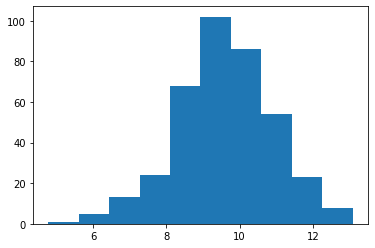

In [80]:
e = HPG_embedding(H, 20)
e.randomly_assign()
e.plot_histogram()
# e.greedily_improve(20000)

In [73]:
e.greedily_improve(20000)

668.6157407407408
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

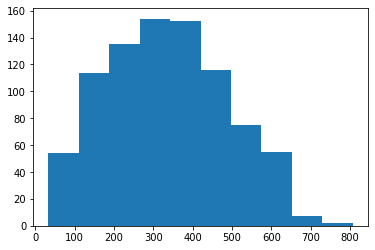

In [74]:
e.plot_histogram()

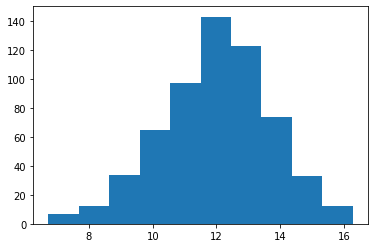

In [27]:
e = HPG_embedding(H, int(np.sqrt(hz.shape[1])))
e.randomly_assign()
# e.greedily_improve(1000)
e.plot_histogram()

10.946508051577753
..............................................................................................................................................................................10.36308060892447


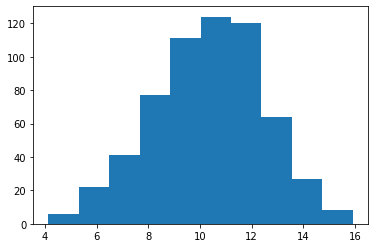

In [29]:
e.greedily_improve(1000)
e.plot_histogram()

In [81]:
e.mis_assign()

35 [0, 3, 133, 136, 9, 140, 16, 146, 19, 151, 25, 154, 33, 36, 166, 171, 46, 177, 50, 55, 184, 58, 189, 64, 67, 73, 81, 84, 94, 98, 103, 106, 117, 120, 124]
0. placed one. 393 spots left
1. placed one. 386 spots left
2. placed one. 379 spots left
3. placed one. 372 spots left
4. placed one. 365 spots left
5. placed one. 358 spots left
6. placed one. 351 spots left
7. placed one. 344 spots left
8. placed one. 337 spots left
9. placed one. 330 spots left
10. placed one. 323 spots left
11. placed one. 316 spots left
12. placed one. 309 spots left
13. placed one. 302 spots left
14. placed one. 295 spots left
15. placed one. 288 spots left
16. placed one. 281 spots left
17. placed one. 274 spots left
18. placed one. 267 spots left
19. placed one. 260 spots left
20. placed one. 253 spots left
21. placed one. 246 spots left
22. placed one. 239 spots left
23. placed one. 232 spots left
24. placed one. 225 spots left
25. placed one. 218 spots left
26. placed one. 211 spots left
27. placed one. 

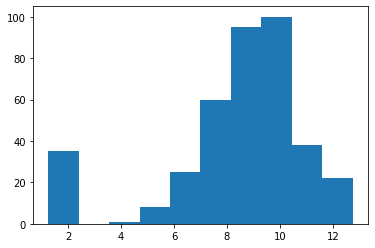

In [82]:
e.plot_histogram()

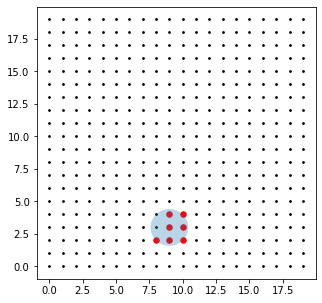

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
pts = itertools.product(np.arange(20), np.arange(20))

i = 25
plt.scatter(*zip(*pts), s=3, c='k')
plt.scatter([qb.loc['x'] for qb in e.X[i].qbs], [qb.loc['y'] for qb in e.X[i].qbs], s=30, c='r')
# plt.scatter(list(zip([c]))[0], list(zip(*stabilizer_coords[c]))[1], s=30, c='r')
c = plt.Circle((e.X[i].c[0], e.X[i].c[1]), e.X[i].c[2], alpha=0.3)
ax.add_artist(c)
plt.show()

In [85]:
e.greedily_improve(1000)

8.374267937462006
...............................................................................................7.926533850317216


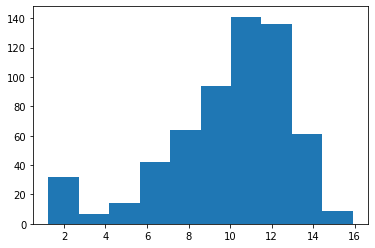

In [35]:
e.plot_histogram()

In [21]:
r =  [s.c[2] for s in e.X + e.Z]
np.argmin(r)

251